# Movie Recommendations with collaborative recommendations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from collections import defaultdict
from typing import List
from tqdm import tqdm


### Read data

In [5]:
data = pd.read_csv('./data/ml-25m/ratings.csv', nrows=100000)
print(data.head(10))

all_movie_counts = len(data['movieId'].unique())
train_data, valid_x, train_y, valid_y = train_test_split(data, data['rating'], test_size=0.2, random_state=0)


   userId  movieId  rating   timestamp
0       1      296     5.0  1147880044
1       1      306     3.5  1147868817
2       1      307     5.0  1147868828
3       1      665     5.0  1147878820
4       1      899     3.5  1147868510
5       1     1088     4.0  1147868495
6       1     1175     3.5  1147868826
7       1     1217     3.5  1147878326
8       1     1237     5.0  1147868839
9       1     1250     4.0  1147868414


### Analyze data

{1: 784, 2: 252, 3: 200, 4: 24, 5: 200, 6: 336, 7: 192, 8: 12, 9: 52, 10: 372, 11: 256, 12: 40, 13: 20, 14: 92, 15: 20, 16: 260, 17: 268, 18: 76, 19: 288, 20: 48, 21: 316, 22: 96, 23: 44, 24: 92, 25: 280, 26: 44, 27: 32, 28: 48, 29: 96, 30: 12, 31: 136, 32: 704, 33: 4, 34: 472, 35: 12, 36: 272, 37: 4, 38: 4, 39: 392, 40: 20, 41: 80, 42: 40, 43: 20, 44: 148, 45: 96, 46: 40, 47: 716, 48: 168, 50: 816, 52: 92, 55: 4, 56: 4, 57: 20, 58: 172, 60: 68, 61: 40, 62: 296, 63: 40, 64: 36, 65: 56, 66: 32, 68: 24, 69: 60, 70: 188, 71: 8, 72: 16, 73: 36, 74: 72, 75: 16, 76: 36, 78: 28, 79: 60, 80: 4, 81: 56, 82: 20, 83: 4, 85: 32, 86: 68, 87: 8, 88: 76, 89: 48, 92: 32, 93: 28, 94: 60, 95: 312, 97: 48, 99: 12, 100: 80, 101: 44, 102: 36, 103: 28, 104: 276, 105: 144, 106: 4, 107: 88, 110: 856, 111: 380, 112: 156, 113: 20, 115: 4, 116: 16, 117: 12, 118: 20, 120: 4, 121: 24, 122: 48, 123: 40, 124: 4, 125: 32, 126: 8, 127: 4, 129: 4, 132: 16, 134: 4, 135: 84, 140: 80, 141: 348, 144: 32, 145: 164, 146: 4, 

Text(0, 0.5, 'popularity')

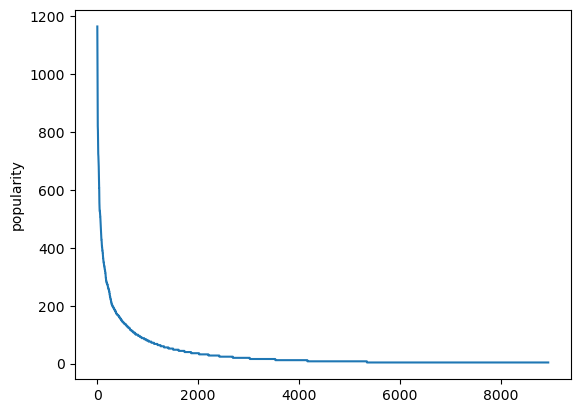

In [26]:
popularity = train_data.groupby('movieId', group_keys=True).apply(lambda g: g.size).to_dict()
print(popularity)
sorted_popularity =list(sorted(popularity.values(), reverse=True))
plt.plot(sorted_popularity)
plt.ylabel('popularity')

### Train test split

In [27]:
# user to movies dictionary
def get_user_movie_dict(data: pd.DataFrame):
    'dict {u_id: pd}'
    return {key: values for (key, values) in data.groupby('userId')}

users = list(set(train_data['userId']))
user_movie_dict = get_user_movie_dict(train_data) 
print(len(users))

757


## Build Latent Factor Model

In [46]:
# configer k vectors

class MyLatentFactorModel:
    def __init__(self, k=10, alpha=0.9, beta=0.1, ratio=0.5):
        '''k is the vector length
        alpha is the learning rate
        beta is the regularization
        ratio is when sample unwatched movies against watched
        '''
        self.K = k
        self.alpha = alpha
        self.beta = beta
        self.user_movie_dict = {}
        self.P = {}
        self.Q = {}
        self.popularity = {}
        self.ratio = ratio
        self.all_movies = set()
        
    def _init_model(self, movie_ratings):
        self.user_movie_dict = get_user_movie_dict(movie_ratings)  
        movies = movie_ratings['movieId'].unique()
        self.P = {user_id: np.random.rand(self.K) for user_id in self.user_movie_dict.keys()}
        self.Q = {movie: np.random.rand(self.K) for movie in movies}    
        self.popularity = movie_ratings.groupby('movieId', group_keys=True).apply(lambda g: g.size).to_dict() 
        self.all_movies = set(movies)
        

    def get_user_movie_dict(data: pd.DataFrame):
        'dict {u_id: pd}'
        return {key: values for (key, values) in data.groupby('userId')}

    def train(self, movie_ratings, epoch=20):        
        self._init_model(movie_ratings) 
        # gradient decent 
        alpha = self.alpha
        for t in tqdm(range(epoch)):
            for u_id, u_movies in self.user_movie_dict.items():
                # calculate the gradient this user to each movie.  
                data = self.get_sample_data(u_id, u_movies)
                for _, m_id, r_ui in data:
                    e_ui = r_ui - np.dot(self.P[u_id], self.Q[m_id])
                    self.P[u_id] += alpha * (e_ui * self.Q[m_id] - self.beta * self.P[u_id])
                    self.Q[m_id] += alpha * (e_ui * self.P[u_id] - self.beta * self.Q[m_id])
            alpha *= 0.9
            print(f'epoch:{t}, alpha: {alpha}')
    
    def get_sample_data(self, u_id, u_movies):
        ''' fill missing ratings for movies that the user hasn't watched.
        return list of user_id, movie_id and rating.
        '''
        pos_movies = set(u_movies['movieId'].to_list())
        neg_movies = list(self.all_movies - pos_movies)
        sample_neg_movies = np.random.choice(neg_movies, size=int(len(pos_movies) * self.ratio), replace=True, p=None )
        
        data = []
        data.extend([(u_id, mv['movieId'], mv['rating']) for _, mv in u_movies.iterrows()])
        data.extend([(u_id, mv, 0) for mv in sample_neg_movies])
        return data
        
    def recommend(self, user_id: str, watched_movies: List[int] = None, k = 10) -> list[str]:
        reco = defaultdict(float)
        watched_movies = set(self.user_movie_dict[user_id]['movieId']) if watched_movies is None else watched_movies
        unwatched_movies = self.all_movies - watched_movies
        for mv in unwatched_movies:
            score = np.dot(self.P[user_id], self.Q[mv])
            reco[mv] = score
        return list(map(lambda x: x[0], sorted(reco.items(), key=lambda x:[1] , reverse=True)[:k]))
    
model = MyLatentFactorModel()
model.train(train_data, 2)
rc = model.recommend(2)
print(rc)
            

  0%|          | 0/2 [00:00<?, ?it/s]C:\Users\Michael\AppData\Local\Temp\ipykernel_15316\4136748642.py:44: RuntimeWarning: overflow encountered in multiply
  self.Q[m_id] += alpha * (e_ui * self.P[u_id] - self.beta * self.Q[m_id])
 50%|█████     | 1/2 [00:06<00:06,  6.07s/it]

epoch:0, alpha: 0.81


100%|██████████| 2/2 [00:11<00:00,  6.00s/it]

epoch:1, alpha: 0.7290000000000001
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


### Test on validation dataset

In [48]:
valid_user_movies = get_user_movie_dict(valid_x)
valid_recommendation = {}
for user_id in tqdm(valid_x['userId']):
     recomendatation = model.recommend(user_id, set(valid_user_movies[user_id]))
     valid_recommendation[user_id] = recomendatation

  0%|          | 0/20000 [00:00<?, ?it/s]

 11%|█         | 2242/20000 [01:22<10:53, 27.19it/s]


KeyboardInterrupt: 

### Metrics


In [72]:
# calc metrics given recommendations and actual movies the users watched. 
# Presision rate = hit / recommended count; recall rate = hit/ actual watched movies; coverage = commendated count/ all movie count.

def calc_metrics(user_recommendated_movies, user_actual_watched_movies, all_movie_counts, n=10000) -> dict:
    hit, user_actual_watched_movies_count, recommended_movies_count = 0, 0, 0
    all_movie_rec = set()
    for user_id, reco in user_recommendated_movies.items():        
        actual_watched_movies = set(user_actual_watched_movies[user_id])
        rec = set(reco[:n])
        hit += len(actual_watched_movies & rec)
        user_actual_watched_movies_count += len(actual_watched_movies)
        recommended_movies_count += len(reco)
        all_movie_rec =all_movie_rec.union(rec)

    return {"precision_rate": hit / recommended_movies_count, "recall_rate": hit / user_actual_watched_movies_count, "coverage_rate": len(all_movie_rec)/all_movie_counts}


{'precision_rate': 0.12169312169312169, 'recall_rate': 0.092, 'coverage_rate': 0.03300633558144288}


In [76]:
metrics = {}
for i in range(5, 10, 5):
    metrics[i] = calc_metrics(valid_recommendation, valid_user_movies, all_movie_counts, i)    
df = pd.DataFrame(metrics)
print(df)

                      5         15        25        35        45        55
precision_rate  0.070503  0.164683  0.199405  0.199405  0.199405  0.199405
recall_rate     0.053300  0.124500  0.150750  0.150750  0.150750  0.150750
coverage_rate   0.023401  0.042203  0.050174  0.050174  0.050174  0.050174
